<a href="https://colab.research.google.com/github/aemrhb/IPI_project-seminar/blob/main/deep_sort_faster_Rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#change to youe path
%cd gdrive/My Drive/faster-Rccn-finetune

/content/gdrive/My Drive/faster-Rccn-finetune


In [4]:
import os
import random
import numpy as np
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [5]:
## run this if faster Rccn is the baseline model

import torch
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the number of classes
num_classes = 3 # Change this to the number of classes in your fine-tuned model
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the model weights
model.load_state_dict(torch.load('fine_tuned_model.pth', map_location=torch.device('cpu')))


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 81.0MB/s]


<All keys matched successfully>

In [ ]:
## run this if the Faster Rcnn train with different anchor size

import torch
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import RPNHead

model = fasterrcnn_resnet50_fpn(pretrained=True)

anchor_sizes = ( (8,), (16,), (32,),(64,) ,(128,),)
aspect_ratios = tuple([( 0.5, 1.0, 2.0,3.0) for _ in range(len(anchor_sizes))])



# Create a new AnchorGenerator with the desired sizes and aspect ratios
anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

# # anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                aspect_ratios=((0.5, 1.0, 2.0),))

# Set the AnchorGenerator in the RPN module of the model
model.rpn.anchor_generator = anchor_generator

# Get the in_channels from the model's backbone
in_channels = model.backbone.out_channels

# Update the box_coder in the RPNHead module to handle the new anchor sizes
model.rpn.head = RPNHead(
    in_channels,
    anchor_generator.num_anchors_per_location()[0]
)

# Get the number of anchor boxes per location in the RPN module
num_anchors = anchor_generator.num_anchors_per_location()[0]

# Update the number of anchor boxes per location in the RPN module
model.rpn.head.conv.num_anchors = num_anchors

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

num_classes = 3
# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('fine_tuned_model_2.pth', map_location=torch.device('cpu')))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-d540a7572964>", line 47, in <cell line: 47>
    model.load_state_dict(torch.load('fine_tuned_model_2.pth', map_location=torch.device('cpu')))
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 791, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 271, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 252, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'fine_tuned_model_2.pth'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/pytho

In [6]:
files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data_test'
imge_path = os.path.join(files_dir)
annots_path  = os.path.join(files_dir ,"annot")

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir,width, height, transforms=None):  # Add necessary arguments for dataset initialization
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = list(sorted(os.listdir(imge_path)))





    def __getitem__(self, idx):
        # Implement dataset item retrieval logic
        # imge_path = os.path.join(self.files_dir , "img1" )
        img_name = self.imgs[idx]
        img_path = os.path.join(imge_path, img_name)
        img = cv2.imread(img_path)
        wt = img.shape[1]
        ht = img.shape[0]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0


        annots_path  = os.path.join(files_dir ,"annot")
        annot_file = img_name[:-4] + '.txt'
        annot_path = os.path.join(annots_path,annot_file)
        with open(annot_path, "r") as file:
          file_contents = file.read()
        lines = file_contents.split("\n")
        data = np.matrix(lines)
        boxes = []
        labels = []
        area = []
        Id = []

        for i in range(data.shape[1] - 1 ):
          boxe = []
          line = data[0,i].split(",")
          # print(line)
          strr = line[2:6]

          res = [float(t) for t in strr]

          xmin_corr = (res[0]/wt)*self.width
          xmax_corr = (res[0]/wt)*self.width + (res[2]/wt)*self.width
          ymin_corr = (res[1]/ht)*self.height
          ymax_corr = (res[1]/ht)*self.height + (res[3]/ht)*self.height

          are = int((res[2] - res[0]) * (res[3] - res[1]))
          area.append(are)
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(float(line[7]))
          Id.append(int(line[1]))



        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        image_id = torch.tensor([idx])
        Id = torch.as_tensor(Id, dtype=torch.int64)


        target = {}

        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id
        target["Id"] = Id

        if self.transforms:

            sample = self.transforms(image = img_res)
                                    #  bboxes = target['boxes'],
                                    #  labels = labels)

            img_res = sample['image']
            # target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target


    def __len__(self):
        # Return the size of the dataset
        return len(self.imgs)


In [ ]:
dataset = CustomDataset(files_dir, 224, 224)


In [8]:
from torchvision.transforms import ToTensor
# dataset = CustomDataset(files_dir, 224, 224)
dataset_test = CustomDataset(files_dir, 480, 480)
img, target = dataset_test[200]
# print(img.shape)
transform = ToTensor()
image_tensor = transform(img)

# Add a batch dimension to the tensor
image_tensor = image_tensor.unsqueeze(0)

model.eval()

with torch.no_grad():
    predictions = model(image_tensor)

EXPECTED OUTPUT


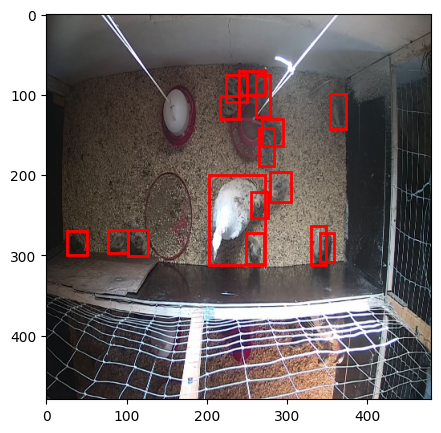

In [9]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()



# plotting the image with bboxes. Feel free to change the index
img, target = dataset_test[200]
print('EXPECTED OUTPUT')
plot_img_bbox(img, target)

MODEL OUTPUT


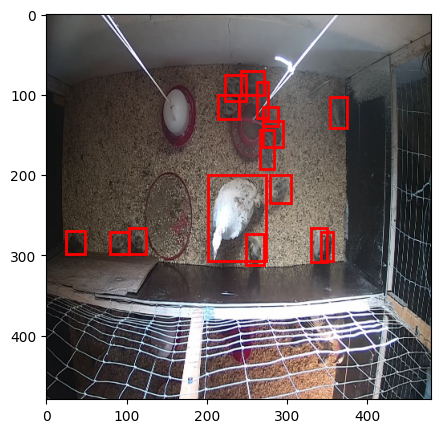

In [10]:
prediction = predictions[0]
prediction = {key: tensor.cpu() for key, tensor in prediction.items()}
print('MODEL OUTPUT')
plot_img_bbox(img, prediction)

In [ ]:
# only run it for once
# git clone https://github.com/computervisioneng/deep_sort.git

In [11]:
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort import nn_matching
from deep_sort.tools import generate_detections as gdet
from deep_sort.deep_sort.detection import Detection
from torchvision.transforms import ToTensor

In [ ]:
# files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data_test'


In [ ]:
# imgs = list(sorted(os.listdir(files_dir)))

In [12]:
# Definition of the parameters
max_cosine_distance = 0.5
nn_budget = None
nms_max_overlap = 1.0

#initialize deep sort
# imprtant you sould upload this file in your dirctory as folwing path
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

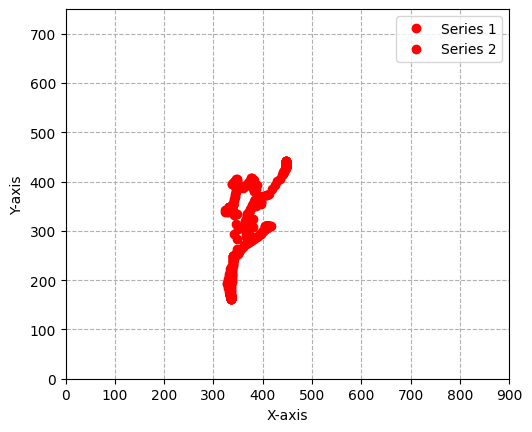

In [ ]:
## ignore it

for i in range(500):
    img, target = dataset_test[i]
    box = target['boxes'][1].numpy()
    top_left_x, top_left_y, width, height = box

    # Calculate center coordinates
    center_x = top_left_x + width // 2
    center_y = top_left_y + height // 2

    # Plot the center point with red color
    plt.plot(center_x, center_y, 'ro')



    # Calculate center coordinates
    # center_x = top_left_x + width // 2
    # center_y = top_left_y + height // 2

    # # Plot the center point with green color
    # plt.plot(center_x, center_y, 'go')


# Set plot limits
plt.xlim(0, 900)
plt.ylim(0, 750)

# Set aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Add grid lines
plt.grid(True, linestyle='--')

# Add legend
plt.legend(['Series 1', 'Series 2'])

# Add axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the plot
plt.show()


In [13]:
import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
from PIL import Image, ImageDraw


def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    blue = (number*30 % 256)
    green = (number*103 % 256)
    red = (number*50 % 256)
    return (blue, green, red)

def draw_bounding_boxess(img, boxes, ides):
    # Create a copy of the image to draw on
    color_dict = {}
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)




    # Iterate over the bounding boxes and IDs
    for id, box in zip(ides, boxes):
        # x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]

        # Get the color for the current ID
        if id in color_dict:
            color = color_dict[id]
        else:
            color_dict[id] = get_color(id)
            color = color_dict[id]


        bounding_box = (box[0], box[1],box[2],box[3])
        draw.rectangle(bounding_box, outline=color)
        text = f"ID: {id}"
        text_width, text_height = draw.textsize(text)
        text_position = (box[0], box[1] - text_height - 5)  # Adjust the vertical offset as needed
        draw.text(text_position, text, fill=color)


    return img


    # Return the image with the drawn rectangles



In [14]:
files_dir = '/content/gdrive/My Drive/Deep_sort_fasterRccn/output_videos'
output_video = os.path.join(files_dir, 'img_Facnsmal_1_5_only1class.mp4')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# video_writer = cv2.VideoWriter(output_video, fourcc, 5, (480, 480))

In [15]:
# change to your path this where you put your images
files_dir = '/content/gdrive/My Drive/faster-Rccn-finetune/data_test'


In [16]:
imgs = list(sorted(os.listdir(files_dir)))

In [ ]:
# ignore
img, target = dataset_test[68]
# print(target)
i = 1
gt_Id = target['boxes'][i].numpy()
x1,y1,x2,y2 = target['boxes'][i].numpy()
gt_box_i = [x1,y1,x2-x1,y2-y1]
print(gt_Id)
print(gt_box_i)

[265.335   195.93333 288.315   229.36667]
[265.335, 195.93333, 22.980011, 33.433334]


In [17]:
#liberay for MOT evaluation :
!pip install motmetrics
import motmetrics as mm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
# ignore
img, target = dataset_test[0]

In [20]:
detection_threshold = 0.5
frames = []
acc = mm.MOTAccumulator(auto_id=True)
for count,i in enumerate(imgs) :

  img_path = os.path.join(files_dir, i)
  img = cv2.imread(img_path)
  wt = img.shape[1]
  ht = img.shape[0]
  width = 480
  height = 480
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img_res = cv2.resize(img_rgb, (width,height), cv2.INTER_AREA)

  img_res /= 255.0
  # video_writer.write(img_res)
  # print(img_res.shape)

  transform = ToTensor()
  image_tensor = transform(img_res)
  image_tensor = image_tensor.unsqueeze(0)

  model.eval()

  with torch.no_grad():
    predictions = model(image_tensor)
  detections = []
  boxes = predictions[0]['boxes'].tolist()
  labels = predictions[0]['labels'].tolist()
  scores = predictions[0]['scores'].tolist()
  for box, label ,score in zip(boxes, labels,scores):
    x1, y1, x2, y2 = box
    scor = score
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    class_id = int(label)
    if scor > detection_threshold:
                detections.append([x1, y1, x2, y2, score])
    bboxes = np.asarray([d[:-1] for d in detections])
  # print(bboxes.shape)
  bboxes[:, 2:] = bboxes[:, 2:] - bboxes[:, 0:2]
  # print(bboxes)
  scores = [d[-1] for d in detections]
  features = encoder(img, bboxes)
  dets = []
  for bbox_id, bbox in enumerate(bboxes):
    # print(bbox,'s',scores[bbox_id],'f',features[bbox_id])
    dets.append(Detection(bbox, scores[bbox_id], features[bbox_id]))
    # dets.append([bbox,scores[bbox_id],features[bbox_id]])
  # print((dets[0:2]))
  # print(type(dets),"class")

  # print(type(dets))

  tracker.predict()
  tracker.update(dets)

  result = []
  pre_box  = []
  pre_id = []
  pre_box_draw  = []
  for track in tracker.tracks:
      if not track.is_confirmed() or track.time_since_update > 1:
          continue
      bbox = track.to_tlbr()
      id = track.track_id

      pre_box.append([bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]])

      pre_box_draw.append([bbox[0], bbox[1], bbox[2], bbox[3]])

      pre_id.append(id)

      result.append([ id, bbox[0], bbox[1], bbox[2], bbox[3]])
  # print(result)
  # print(pre_box
  imge = draw_bounding_boxess(img_res,pre_box_draw,pre_id)

  imge.save(f"saved_image_{i}.jpg")
  frames.append(imge)

  #evaluation :
  #providing Ground trouth :
  img, target = dataset_test[count]
  gt_box = []
  for i in range(16) :
    x1,y1,x2,y2 = target['boxes'][i].numpy()
    gt_box_i = [x1,y1,x2-x1,y2-y1]
    gt_box.append(gt_box_i)




  gt_Id = target['Id'].numpy()
  distance_matrix = mm.distances.iou_matrix(gt_box, pre_box,max_iou=0.7)
  acc.update(
  gt_Id,                     # Ground truth object ID in this frame
  pre_id,                  # Detector hypothesis ID in this frame
  [distance_matrix])
  # print(distance_matrix)




  # plt.imshow(imges)
  # plt.axis('off')  # Hide axis labels
  # plt.show()
  # imges = cv2.convertScaleAbs(imges)
  # imge = cv2.cvtColor(imge, cv2.COLOR_BGR2GRAY)
  # imge = cv2.cvtColor(imge, cv2.COLOR_GRAY2BGR)
#   plt.imshow(imge)
#   plt.axis('off')  # Hide axis labels
#   plt.show()
#   # video_writer.write(imge)
# fps = 12.0
# imageio.mimsave(output_video, frames, fps=fps)
# Release the video writer and close the video file
# video_writer.release()





AttributeError: ignored

In [ ]:
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['num_frames', 'mota', 'motp'], name='acc')
print(summary)

     num_frames      mota      motp
acc         500  0.861375  0.232643


In [ ]:
report = mh.compute(acc, metrics=['num_frames', 'num_objects','num_matches' ,'mota','motp', 'num_misses','num_false_positives','num_switches','mostly_tracked','partially_tracked','mostly_lost' ,'idf1'], name='acc')
print(report)

     num_frames  num_objects  num_matches      mota      motp  num_misses  \
acc         500         8000         7333  0.861375  0.232643         645   

     num_false_positives  num_switches  mostly_tracked  partially_tracked  \
acc                  442            22              15                  1   

     mostly_lost      idf1  
acc            0  0.794328  


In [ ]:
report = mh.compute(acc, metrics=['num_frames', 'num_objects','num_matches' ,'mota','motp', 'num_misses','num_false_positives','num_switches','mostly_tracked','partially_tracked','mostly_lost' ,'idf1'], name='acc')
print(report)

     num_frames  num_objects  num_matches      mota      motp  num_misses  \
acc         500         8000         6399  0.716375  0.276715        1534   

     num_false_positives  num_switches  mostly_tracked  partially_tracked  \
acc                  668            67              10                  6   

     mostly_lost      idf1  
acc            0  0.582397  


In [ ]:
mh = mm.metrics.create()
report = mh.compute(acc, metrics=['num_frames', 'num_objects','num_matches' ,'mota','motp', 'num_misses','num_false_positives','num_switches','mostly_tracked','partially_tracked','mostly_lost' ,'idf1'], name='acc')
print(report)

     num_frames  num_objects  num_matches      mota      motp  num_misses  \
acc         500         8000         6666  0.712625  0.282233        1253   

     num_false_positives  num_switches  mostly_tracked  partially_tracked  \
acc                  965            81              12                  4   

     mostly_lost      idf1  
acc            0  0.621818  


In [ ]:
mh = mm.metrics.create()
report = mh.compute(acc, metrics=['num_frames', 'num_objects','num_matches' ,'mota','motp', 'num_misses','num_false_positives','num_switches','mostly_tracked','partially_tracked','mostly_lost' ,'idf1'], name='acc')
print(report)

     num_frames  num_objects  num_matches      mota      motp  num_misses  \
acc         500         8000         6288  0.728375  0.284053        1638   

     num_false_positives  num_switches  mostly_tracked  partially_tracked  \
acc                  461            74               9                  7   

     mostly_lost      idf1  
acc            0  0.586656  


In [ ]:
# only one class
mh = mm.metrics.create()
report = mh.compute(acc, metrics=['num_frames', 'num_objects','num_matches' ,'mota','motp', 'num_misses','num_false_positives','num_switches','mostly_tracked','partially_tracked','mostly_lost' ,'idf1'], name='acc')
print(report)

     num_frames  num_objects  num_matches   mota      motp  num_misses  \
acc         500         8000         6992  0.777  0.248398         970   

     num_false_positives  num_switches  mostly_tracked  partially_tracked  \
acc                  776            38              14                  1   

     mostly_lost      idf1  
acc            1  0.692142  


In [19]:
# only one class
mh = mm.metrics.create()
report = mh.compute(acc, metrics=['num_frames', 'num_objects','num_matches' ,'mota','motp', 'num_misses','num_false_positives','num_switches','mostly_tracked','partially_tracked','mostly_lost' ,'idf1'], name='acc')
print(report)

     num_frames  num_objects  num_matches      mota      motp  num_misses  \
acc         500         8000         7333  0.861375  0.232648         645   

     num_false_positives  num_switches  mostly_tracked  partially_tracked  \
acc                  442            22              15                  1   

     mostly_lost      idf1  
acc            0  0.794328  


In [ ]:
import imageio
fps = 6.0
imageio.mimsave(output_video, frames, fps=fps)
